# Preprocessing & Exploratory Analysis

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
crypto_df = pd.read_csv('/content/drive/MyDrive/CS 539/final project/train.csv')
asset_details_df = pd.read_csv('/content/drive/MyDrive/CS 539/final project/asset_details.csv')

In [ ]:
#start with a smaller dataset
print(crypto_df.shape)
crypto_df = crypto_df[:50000]

(24236806, 10)


In [ ]:
crypto_df.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,48522.000000
mean,1.514957e+09,5.087000,109.052100,2332.522005,2354.813247,2314.186906,2332.630643,735.002132,2332.527774,0.000364
std,1.103176e+05,3.631635,147.107864,4670.218154,4718.527824,4631.427209,4670.507609,2749.738851,4670.264301,0.009323
min,1.514765e+09,0.000000,1.000000,7.214700,7.251300,7.200000,7.234600,0.000009,7.210550,-0.091524
25%,1.514862e+09,1.000000,12.000000,28.059125,28.247250,27.905250,28.076375,36.207203,28.067210,-0.003993
50%,1.514957e+09,5.000000,43.000000,319.030000,319.420000,318.720000,319.345000,175.470926,319.132511,0.000117
75%,1.515053e+09,7.000000,157.000000,2306.916250,2317.910000,2290.375000,2306.527500,576.813634,2306.232741,0.004425
max,1.515147e+09,11.000000,1591.000000,15996.600000,16179.000000,15899.980000,16002.845636,234325.621576,16001.109454,0.109310


In [ ]:
crypto_df.isna().sum()

timestamp       0
Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target       1478
dtype: int64

In [ ]:
#data cleaning to get rid of infinities and nan's
crypto_df.replace([np.inf, -np.inf], np.nan, inplace=True)
crypto_df.dropna(inplace=True)
crypto_df.drop_duplicates(inplace=True)

# Feature Engineering

In [ ]:
#convert timestamp to actual time
crypto_df['date_time'] = crypto_df['timestamp'].map(datetime.fromtimestamp)

First, constructe some new variables and standardize the existing variables

In [ ]:
#constructing time feature
crypto_df['date_time'] = pd.to_datetime(crypto_df['timestamp'],unit='s')    
crypto_df['year'] = pd.DatetimeIndex(crypto_df['date_time']).year
crypto_df['month'] = pd.DatetimeIndex(crypto_df['date_time']).month
crypto_df['day']=pd.DatetimeIndex(crypto_df['date_time']).day
crypto_df['hour']=pd.DatetimeIndex(crypto_df['date_time']).hour
crypto_df['minute']=pd.DatetimeIndex(crypto_df['date_time']).minute

crypto_df['sin_month'] = (np.sin(2 * np.pi * crypto_df['month']/12))
crypto_df['cos_month'] = (np.cos(2 * np.pi * crypto_df['month']/12))
crypto_df['sin_day'] = (np.sin(2 * np.pi * crypto_df['day']/31))
crypto_df['cos_day'] = (np.cos(2 * np.pi * crypto_df['day']/31))
crypto_df['sin_hour'] = (np.sin(2 * np.pi * crypto_df['hour']/24))
crypto_df['cos_hour'] = (np.cos(2 * np.pi * crypto_df['hour']/24))
crypto_df['sin_minute'] = (np.sin(2 * np.pi * crypto_df['minute']/60))
crypto_df['cos_minute'] = (np.cos(2 * np.pi * crypto_df['minute']/60))

In [ ]:
#constructing market features
# Standardising Features
Base=crypto_df['Close']
crypto_df['Open'] = crypto_df['Open']/Base
crypto_df['High'] = crypto_df['High']/Base
crypto_df['Low'] = crypto_df['Low']/Base
crypto_df['VWAP'] = crypto_df['VWAP']/Base
crypto_df['Close'] = crypto_df['Close']/Base
crypto_df['Price'] = Base

# Using dollars
crypto_df['Dollars'] = crypto_df['Price'] * crypto_df['Volume']
crypto_df['Volume_per_trade'] = crypto_df['Volume'] * crypto_df['Count']
crypto_df['Dollars_per_trade'] = crypto_df['Dollars'] * crypto_df['Count']

# log returns and volatility estimators
crypto_df['log_ret'] = np.log(crypto_df['Close']/crypto_df['Open'])
crypto_df['GK_vol'] = (1 / 2 * np.log(crypto_df['High']/crypto_df['Low']) ** 2 - (2 * np.log(2) - 1) * np.log(crypto_df['Close'] / crypto_df['Open']) ** 2)
crypto_df['RS_vol'] = np.log(crypto_df['High']/crypto_df['Close'])*np.log(crypto_df['High']/crypto_df['Open']) + np.log(crypto_df['Low']/crypto_df['Close'])*np.log(crypto_df['Low']/crypto_df['Open'])

# Benchmark method 1: linear regression

In [ ]:
Target = crypto_df['Target']
crypto_df = crypto_df.drop('Target',axis=1)
#get rid of some variables as they are not allowed in random forest
crypto_df = crypto_df.drop('timestamp',axis=1)
crypto_df = crypto_df.drop('date_time',axis=1)

In [ ]:
#prepare data for linear regression
from sklearn.model_selection import train_test_split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(crypto_df, Target, test_size = 0.2, random_state = 42)

scaler = MinMaxScaler().fit(X_train_lr)
X_train_lr = scaler.transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

scaler = MinMaxScaler().fit(y_train_lr.values.reshape(-1,1))
y_train_lr = scaler.transform(y_train_lr.values.reshape(-1,1))
y_test_lr = scaler.transform(y_test_lr.values.reshape(-1,1))

In [ ]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression().fit(X_train_lr,y_train_lr)

In [ ]:
#linear regression model prediction & evaluation
pred_lr = model_lr.predict(X_test_lr)
mse_lr = np.sqrt(np.mean(pred_lr - y_test_lr)**2)
mse_lr

0.0003675420105372296

# Benchmark method 2: Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets for rf
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(crypto_df, Target, test_size = 0.2, random_state = 42)

scaler = MinMaxScaler().fit(X_train_rf)
X_train_rf = scaler.transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf)

scaler = MinMaxScaler().fit(y_train_rf.values.reshape(-1,1))
y_train_rf = scaler.transform(y_train_rf.values.reshape(-1,1))
y_test_rf = scaler.transform(y_test_rf.values.reshape(-1,1))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train_rf, y_train_rf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(n_estimators=1000, random_state=42)

In [ ]:
#predict and evaluate
pred_rf = rf.predict(X_test_rf)
mse_rf = np.sqrt(np.mean(pred_rf - y_test_rf)**2)
mse_rf

0.0005326838864260761

# LSTM neural network model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Masking,Dropout
from keras.layers import LSTM 
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets for LSTM model
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(crypto_df, Target, test_size = 0.2, random_state = 42)
# standardize variables
scaler_lstm_X = MinMaxScaler().fit(X_train_lstm)
X_train_lstm = scaler_lstm_X.transform(X_train_lstm)
X_test_lstm = scaler_lstm_X.transform(X_test_lstm)

scaler_lstm_y = MinMaxScaler().fit(y_train_lstm.values.reshape(-1,1))
y_train_lstm = scaler_lstm_y.transform(y_train_lstm.values.reshape(-1,1))
y_test_lstm = scaler_lstm_y.transform(y_test_lstm.values.reshape(-1,1))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
number_units = 20 
drop_out_fraction = 0.2 # 20% of neurons will be randomly droped during each epoch


model = Sequential()

# add 1st layer
model.add(LSTM(units = number_units, 
               activation='relu',
               return_sequences = True,  
               input_shape = (X_train_lstm.shape[1],1)
          ))
model.add(Dropout(drop_out_fraction))
# add 2nd layer
model.add(LSTM(units = number_units, 
               activation='relu',
               return_sequences=True))
model.add(Dropout(drop_out_fraction))
# add 3rd layer 
model.add(LSTM(units = number_units))
model.add(Dropout(drop_out_fraction))

# add output layer
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 28, 20)            1760      
                                                                 
 dropout_6 (Dropout)         (None, 28, 20)            0         
                                                                 
 lstm_7 (LSTM)               (None, 28, 20)            3280      
                                                                 
 dropout_7 (Dropout)         (None, 28, 20)            0         
                                                                 
 lstm_8 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
model.fit(X_train_lstm,y_train_lstm, epochs =10, batch_size=10, shuffle=False)

Epoch 1/10
3882/3882 [==============================] - 132s 33ms/step - loss: 0.0041 - mse: 0.0041
Epoch 2/10
3882/3882 [==============================] - 133s 34ms/step - loss: 0.0022 - mse: 0.0022
Epoch 3/10
3882/3882 [==============================] - 127s 33ms/step - loss: 0.0022 - mse: 0.0022
Epoch 4/10
3882/3882 [==============================] - 127s 33ms/step - loss: 0.0022 - mse: 0.0022
Epoch 5/10
3882/3882 [==============================] - 127s 33ms/step - loss: 0.0022 - mse: 0.0022
Epoch 6/10
3882/3882 [==============================] - 126s 33ms/step - loss: 0.0022 - mse: 0.0022
Epoch 7/10
3882/3882 [==============================] - 133s 34ms/step - loss: 0.0022 - mse: 0.0022
Epoch 8/10
3882/3882 [==============================] - 127s 33ms/step - loss: 0.0022 - mse: 0.0022
Epoch 9/10
3882/3882 [==============================] - 126s 32ms/step - loss: 0.0022 - mse: 0.0022
Epoch 10/10
3882/3882 [==============================] - 126s 32ms/step - loss: 0.0022 - mse: 0.0022

In [ ]:
pred_lstm = model.predict(X_test_lstm).flatten()
mse_lstm = np.sqrt(np.mean(pred_lstm - y_test_lstm)**2)
mse_lstm

1.6709741708613678e-05

# Visualization

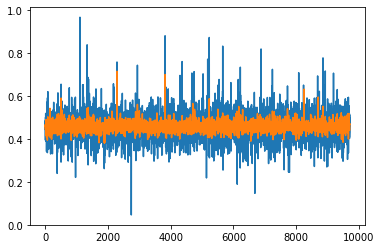

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_lstm)
plt.plot(pred_rf)